# β-Scaling for PIGS Simulations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from graphenetools import gt
import re,glob,os
from scipy.signal import argrelextrema
from scipy.optimize import brentq
import multiprocessing 
import sys,importlib
from dgutils import colors as colortools
from collections import defaultdict
import pickle
from numpy import pi as π

# Notebook display options
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# plot style
plot_style = {'notebook':'../include/notebook.mplstyle','aps':'../include/aps.mplstyle'}
plt.style.reload_library()
plt.style.use(plot_style['aps'])
figsize = plt.rcParams['figure.figsize']
plt.rcParams['text.latex.preamble'] = f'\input{{{os.getcwd()}/../include/texheader}}'

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Do you want to process the full data set?

Default is False. The full data set can be found here: 

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.4553524.svg)](https://doi.org/10.5281/zenodo.4553524)

A minimal set of reduced (averaged and processed) data files is included with the repository `../data/QMC.tar.bz2`.  We can extract if it hasn't already happened.

In [2]:
reduce_data = False
if not os.path.isdir('../data/QMC/'):
    ! tar xjf ../data/QMC.tar.bz2

## Some helper and analysis functions

In [4]:
import layerutils
from layerutils import lab,vals,texformat,get_base_dir

from pimcscripts import pimchelp
importlib.reload(pimchelp)

<module 'pimcscripts.pimchelp' from '/Users/agdelma/opt/miniconda3/lib/python3.9/site-packages/pimcscripts/pimchelp.py'>

## Setting up and Extracting Information from the QMC Data

In [5]:
num_sites = [4]
filling = [1]
sim_params = {'T':0,'canonical':True,'τ':0.00313}

pimcid = defaultdict(dict)
par_map = defaultdict(dict)
base_dir = defaultdict(dict)
L,n,N,τ = defaultdict(dict),defaultdict(dict),defaultdict(dict),defaultdict(dict)
N_ads = defaultdict(dict)
simulations,pimcids = {},{}
Lz = np.arange(4.5,5.51,0.05)

for cnum in num_sites:
    Nkey = lab(N=cnum)
        
    # we consider unit filling here
    cbase_dir = f'{get_base_dir(cnum)}PIGS/'
    log_names = pimchelp.get_file_list_from_params(**sim_params, N=cnum,
                                                       base_dir=get_base_dir(cnum,sim_params['T']))   

    # We go through each file and automatically populate the simulation map
    for log in log_names:
        par_ = pimchelp.get_parameter_map(cbase_dir + log)

        cN = par_['Initial Number Particles']
        cf = cN/cnum
        β = par_['Imaginary Time Length']

        sim = lab(T=sim_params['T'],n=cf,Lz=par_['Container Length'],N=cnum,β=β)
        pimcid[Nkey][sim] = par_['PIMCID']
        par_map[Nkey][sim] = par_

        # We add some short-hand variables for ease of referencing
        L[Nkey][sim] = par_map[Nkey][sim]['Container Dimensions']
        n[Nkey][sim] = par_map[Nkey][sim]['Initial Density']
        N[Nkey][sim] = par_map[Nkey][sim]['Initial Number Particles']
        τ[Nkey][sim] = par_map[Nkey][sim]['Specified Imaginary Time Step']

    simulations[Nkey] = list(pimcid[Nkey].keys())
    pimcids[Nkey] = list(pimcid[Nkey].values())

## Reduce Estimator Files to get the Energy and load the data

In [7]:
if reduce_data:
    !reduce-one.py -r T -N {num_sites[0]} -s 0.2 -t {sim_params['τ']} --canonical {cbase_dir}

In [8]:
estimator,ρlin = {},{}

for cnum in num_sites:
    cNkey = lab(N=cnum)
    reduce_name = pimchelp.get_reduce_name(N=4,τ=sim_params['τ'],canonical=True,reduce='T', estimator='estimator')
    estimator[cNkey] = pimchelp.PIMCResults(f'{cbase_dir}{reduce_name}')
    reduce_name = pimchelp.get_reduce_name(N=4,τ=sim_params['τ'],canonical=True,reduce='T', estimator='lineardensity')
    ρlin[cNkey] = pimchelp.PIMCResults(f'{cbase_dir}{reduce_name}')

## Energetic Convergence

In [9]:
from scipy.optimize import curve_fit

def expfunc(x,a0,a1,a2):
    return a0 + a1*np.exp(-a2*x)

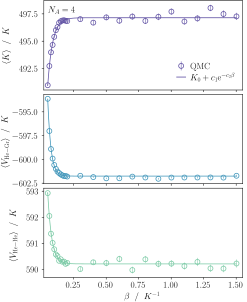

In [10]:
β = 1.0/estimator[cNkey].data['T']
N = num_sites[0]

est_labels = ['K','V_ext','V_int']
est_ylabels = ['Kinetic per Particle(K)', 'External Potential (K)', 'Interaction Potential (K)']
est_ylabels = [r'$\langle K \rangle \;\; / \;\; K$', 
               r'$\langle V_{\rm He-Gr} \rangle \;\; / \;\; K$', r'$\langle V_{\rm He-He}\rangle \;\; / \;\; K$']

guess = [-1,1,-1]
fig, axes = plt.subplots(3,1,sharex=True, sharey=False, squeeze=True,figsize=(1.05*figsize[0],3/2*figsize[0]))
fig.subplots_adjust(wspace=0.35, hspace=0.05)
params = {'mfc':'None', 'elinewidth':0.5, 'marker':'o', 'ms':5, 'lw':0.75, 'ls':'None','mew':0.75}

β_fit = np.linspace(.05,1.5,1000)
for i,ax in enumerate(axes.flatten()):
    elab = est_labels[i]
    Δelab = f'Δ{elab}'
    
    p0 = (1,guess[i],1)
    popt,pcov = curve_fit(expfunc,β,estimator[cNkey].data[elab][:]/N,sigma=estimator[cNkey].data[Δelab][:]/N,p0=p0)
    ax.plot(β_fit,4*expfunc(β_fit,*popt), color=colors[i], lw=0.75, zorder=-10,
            label=r'$K_0 + c_1\mathrm{e}^{-c_2\beta}$')
    ax.errorbar(β[:],estimator[cNkey].data[elab][:],yerr=estimator[cNkey].data[Δelab][:],**params, 
                color=colors[i], label='QMC')
        
    ax.set_xlim(.02,1.55)
    

axes[0].set_ylabel(est_ylabels[0],labelpad=8)
axes[1].set_ylabel(est_ylabels[1])
axes[2].set_ylabel(est_ylabels[2],labelpad=8)
axes[-1].set_xlabel(r'$\beta\;\; / \;\; K^{-1}$')



axes[0].annotate(f'$N_A = {N}$', xy=(0.02,0.85),xytext=(0.02,0.85), 
                            xycoords='axes fraction', ha='left', va='bottom')
#axes[1].set_ylim(493,497.9)
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles[::-1], labels[::-1],loc=(0.65,0.05), handlelength=1)


## Combining with $\tau$ scaling results

We need to peform the imaginary time step scaling analysis found in: [tau_scaling_PIGS](./tau_scaling_PIGS.ipynb)

In [11]:
with open('../data/tau_scaling.pickle','rb') as handle:
    τ_fit,τ_est = pickle.load(handle) 

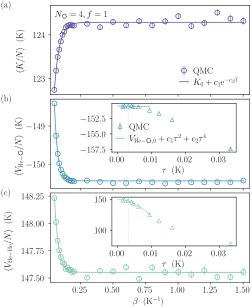

In [12]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

β = 1.0/estimator[cNkey].data['T']
N = num_sites[0]

est_labels = ['K','V_ext','V_int']
est_ylabels = [r'$\alabel{\expval{K/N}}{\kelvin}$', 
               r'$\alabel{\expval{V_{\rm He-\graphene}/N}}{\kelvin}$', 
               r'$\alabel{\expval{V_{\rm He-He}/N}}{\kelvin}$']

guess = [-1,1,-1]
fig, axes = plt.subplots(3,1,sharex=True, sharey=False, squeeze=True,figsize=(1.05*figsize[0],3/2*figsize[0]))
fig.subplots_adjust(wspace=0.35, hspace=0.05)
params = {'mfc':'None', 'elinewidth':0.5, 'marker':'o', 'ms':5, 'lw':0.75, 'ls':'None','mew':0.75}
plabel = ['(a)','(b)','(c)']
β_fit = np.linspace(.05,1.5,1000)
for i,ax in enumerate(axes.flatten()):
    elab = est_labels[i]
    Δelab = f'Δ{elab}'
    
    p0 = (1,guess[i],1)
    popt,pcov = curve_fit(expfunc,β,estimator[cNkey].data[elab][:]/N,sigma=estimator[cNkey].data[Δelab][:]/N,p0=p0)
    ax.plot(β_fit,expfunc(β_fit,*popt), color=colors[i], lw=0.75, zorder=-10,
            label=r'$K_0 + c_1\mathrm{e}^{-c_2\beta}$')
    ax.errorbar(β[:],estimator[cNkey].data[elab][:]/N,yerr=estimator[cNkey].data[Δelab][:]/N,**params, 
                color=colors[i], label='QMC')
        
    ax.set_xlim(.02,1.55)
    ax.annotate(plabel[i], xy=(-0.25,1.05),ha='left', va='top', xycoords='axes fraction')

    
axes[0].set_ylabel(est_ylabels[0],labelpad=8)
axes[1].set_ylabel(est_ylabels[1])
axes[2].set_ylabel(est_ylabels[2],labelpad=8)
axes[-1].set_xlabel(r'$\alabel{\beta}{\per\kelvin}$')
axes[-1].set_ylim(ymin=147.46)


axes[0].annotate(f'$N_\graphene = {N}, f=1$', xy=(0.02,0.85),xytext=(0.02,0.85), 
                            xycoords='axes fraction', ha='left', va='bottom')
#axes[1].set_ylim(493,497.9)
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles[::-1], labels[::-1],loc=(0.63,0.05), handlelength=1)

## Now do the insets
inset_params = {'mfc':'None', 'elinewidth':0.5, 'marker':'^', 'ms':4, 'lw':0.5, 'ls':'None','mew':0.5}

axins = [None]
for i in range(1,3):
    axins.append(inset_axes(ax, width="80%", height="70%",
                    bbox_to_anchor=(.175, .224, .78, .78),
                    bbox_transform=axes[i].transAxes))
    axins[i].set_xlabel(r'$\alabel{\tau}{\kelvin}$')
    #axins[i].set_ylabel(est_ylabels[i])
    
    elab = est_labels[i]
    Δelab = f'Δ{elab}'
    axins[i].plot(τ_fit[elab][0],τ_fit[elab][1]/N, color=colors[i], lw=0.5, zorder=-10,
            label=r'$V_{\rm He-\graphene,0} + c_1\tau^2 + c_2 \tau^4$')
    axins[i].errorbar(τ_est['t'],τ_est[elab]/N,yerr=τ_est[Δelab]/N,**inset_params, 
                color=colors[i], label='QMC')
    axins[i].axvline(x=0.00313,color='gray', ls=':', zorder=-10, alpha=0.5,lw=0.5)

    
    

handles, labels = axins[1].get_legend_handles_labels()
axins[1].legend(handles[::-1], labels[::-1],loc=(0.0,0.1), handlelength=1)

plt.savefig('../plots/beta_tau_scaling.pdf',dpi=300)
plt.savefig('../plots/beta_tau_scaling.svg')

## Structural Convergence

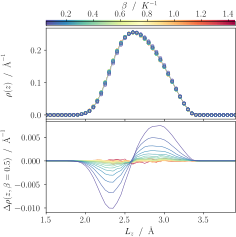

In [13]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.ticker as ticker
import matplotlib as mpl

β_colors = colortools.get_linear_colors('Spectral',len(ρlin[cNkey].params),reverse=False)

x0,y0,Δy0 = ρlin[cNkey].epdata(ρlin[cNkey].params[11])
fig, axes = plt.subplots(2,1,sharex=True, sharey=False, squeeze=True, figsize=(figsize[0],figsize[0]))
fig.subplots_adjust(hspace=0.025)
params = {'mfc':'None', 'elinewidth':0.5, 'marker':'o', 'ms':3, 'lw':0.1, 'ls':'--', 'mew':0.5}

for i,cp in enumerate(ρlin[cNkey].params[::1]):
    x,y,Δy = ρlin[cNkey].epdata(cp)
    xs = np.copy(x)
    xs += L[lab(N=4)][sim][-1]/2
    axes[0].errorbar(xs,y,Δy, **params, label=cp,color=β_colors[i])
    axes[1].plot(xs,y-y0, lw=0.5,color=β_colors[i])

axes[0].set_xlim(1.5,3.9)
axes[0].set_ylabel(r'$\rho(z)\;\;/\;\; \mathrm{\AA}^{-1}$', labelpad=18)
#axes[1].set_ylabel(r'$\rho(z)-\rho(z)|_{\beta = 0.5}\;\;/\;\; \mathrm{\AA}^{-1}$')
axes[1].set_ylabel(r'$\Delta \rho(z,\beta=0.5)\;\;/\;\; \mathrm{\AA}^{-1}$')

axes[1].set_xlabel(r'$L_z\;\;/\;\;\mathrm{\AA}$')

#axes[0].legend(ncol=2)


# The colorbar
# vertical RHS
# loc = 'upper right'
# axins1 = inset_axes(axes[0],
#                     width="5%",  # width = 50% of parent_bbox width
#                     height="120%",  # height : 5%
#                     loc=loc,
#                     bbox_to_anchor=(0.075, -0.5, 1.0, 1.0),
#                     bbox_transform=axes[0].transAxes,
#                     borderpad=0)

# horizontal TOP
loc = 'upper left'
axins1 = inset_axes(axes[0],
                    width="100%",  # width = 50% of parent_bbox width
                    height="5%",  # height : 5%
                    loc=loc,
                    bbox_to_anchor=(0.0, 0.075, 1.0, 1.0),
                    bbox_transform=axes[0].transAxes,
                    borderpad=0)


sm = plt.cm.ScalarMappable(cmap=mpl.cm.Spectral_r, norm=plt.Normalize(vmin=np.min(β), vmax=1.45))
sm._A = []
cb = fig.colorbar(sm, cax=axins1, label=r'$\beta \;\;/\;\;K^{-1}$', orientation='horizontal')
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')
cb.ax.xaxis.set_tick_params(pad=1)

plt.savefig('../plots/rhoz_beta_scaling.pdf',dpi=300)